# Imports

In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_9471/2174054843.py:8: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
%%R
library(tidyverse)
library(dyno)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: dynfeature
Loading required package: dynguidelines
Loading required package: dynmethods
Loading required package: dynplot
Loading required package: dynwrap
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


# Loading Data

In [4]:
%%R
data <- readRDS("multifurcating_1.rds")

In [5]:
%%R
str(data)

List of 17
 $ id                   : chr "synthetic/splatter/multifurcating_1"


 $ cell_ids             : chr [1:920] "Cell1" "Cell2" "Cell3" "Cell4" ...
 $ cell_info            : NULL
 $ counts               : num [1:920, 1:1254] 48 0 0 18 31 38 11 31 19 17 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:920] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. ..$ : chr [1:1254] "Gene4247" "Gene4771" "Gene2697" "Gene3227" ...
 $ expression           : num [1:920, 1:1254] 5.25 0 0 4.26 4.36 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:920] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. ..$ : chr [1:1254] "Gene4247" "Gene4771" "Gene2697" "Gene3227" ...
 $ feature_info         : tibble [1,254 × 1] (S3: tbl_df/tbl/data.frame)
  ..$ feature_id: chr [1:1254] "Gene4247" "Gene4771" "Gene2697" "Gene3227" ...
 $ milestone_ids        : chr [1:9] "M1" "M3" "M6" "M8" ...
 $ milestone_network    : tibble [8 × 4] (S3: tbl_df/tbl/data.frame)
  ..$ from    : chr [1:8] "M1" "M3" "M6" "M3" ...
  ..$ to      : chr [1:8] "M3" "M2" "M7" "M6" ...
  ..$ length  : num [1:8] 0.349 

In [6]:
%%R
counts <- data$counts
expression <- data$expression

In [7]:
%%R
dataset <- wrap_expression(
  expression = expression,
  counts = counts
)

In [8]:
%%R --o grouping
grouping <- data$grouping

In [9]:
%%R
dataset <- add_prior_information(
    dataset,
    start_id = data$prior_information$start_id,
    end_id = data$prior_information$end_id,
    groups_id = data$prior_information$groups_id,
    end_n = data$prior_information$end_n,
)
dataset <- add_grouping(
    dataset,
    data$grouping
)

In [10]:
%%R
umap_dimred <- dyndimred::dimred_umap(dataset$expression)

Loading required namespace: uwot


In [38]:
%%R
pca_dimred <- dyndimred::dimred_pca(dataset$expression, ndim=20)

In [12]:
%%R

kmeans_clusters <- kmeans(pca_dimred, centers=3, nstart=25)

pca_dimred_df <- as.data.frame(pca_dimred)
pca_dimred_df$cluster <- as.factor(kmeans_clusters$cluster)
# ggplot(pca_dimred_df, aes(x=comp_1, y=comp_2, color=cluster)) +
#   geom_point() +
#   labs(title="K-means Clustering on PCA-reduced Data", x="PCA 1", y="PCA 2")

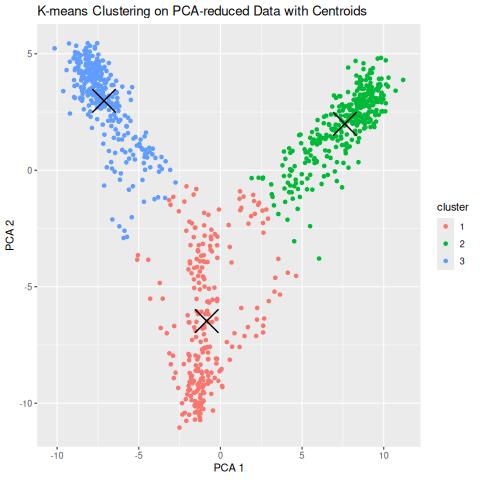

In [13]:
%%R

# Extract centroids
centroids <- as.data.frame(kmeans_clusters$centers)
colnames(centroids) <- colnames(pca_dimred_df)[1:2]

# Plot clusters with centroids
ggplot(pca_dimred_df, aes(x=comp_1, y=comp_2, color=cluster)) +
    geom_point() +
    geom_point(data=centroids, aes(x=comp_1, y=comp_2), color='black', size=10, shape=4, stroke=1) +
    labs(title="K-means Clustering on PCA-reduced Data with Centroids", x="PCA 1", y="PCA 2")

In [14]:
%%R
centroids

      comp_1    comp_2
1 -0.8406568 -6.473822
2  7.6184340  1.993359
3 -7.1289555  2.981934


# DPT Model

In [15]:
%%R
dpt_model <- infer_trajectory(dataset, ti_dpt(), give_priors = c("start_id"))

Loading required namespace: RColorBrewer


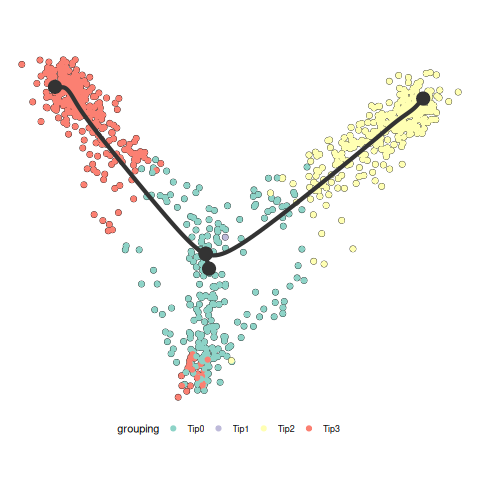

In [16]:
%%R
plot_dimred(dpt_model, color_cells=c("grouping"), dimred=pca_dimred)

In [17]:
%%R
names(dpt_model)

 [1] "id"                          "cell_ids"                   
 [3] "cell_info"                   "group_ids"                  
 [5] "grouping"                    "milestone_ids"              
 [7] "milestone_network"           "divergence_regions"         
 [9] "milestone_percentages"       "progressions"               
[11] "trajectory_type"             "directed"                   
[13] "dimred"                      "dimred_projected"           
[15] "dimred_milestones"           "dimred_segment_progressions"
[17] "dimred_segment_points"      


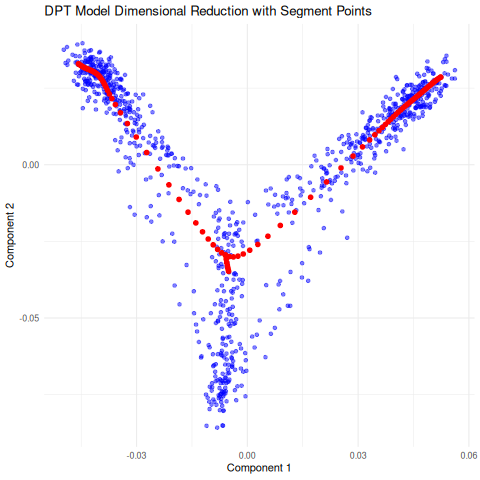

In [19]:
%%R
# Extract the segment points and the dimensional reduction data
segment_points <- dpt_model$dimred_segment_points
dimred_data <- dpt_model$dimred

# Convert to data frames for ggplot
segment_points_df <- as.data.frame(segment_points)
dimred_data_df <- as.data.frame(dimred_data)

# Plot the dimensional reduction data with segment points
ggplot() +
    geom_point(data = dimred_data_df, aes(x = comp_1, y = comp_2), color = "blue", alpha = 0.5) +
    geom_point(data = segment_points_df, aes(x = comp_1, y = comp_2), color = "red", size = 2) +
    labs(title = "DPT Model Dimensional Reduction with Segment Points", x = "Component 1", y = "Component 2") +
    theme_minimal()

In [39]:
%%R
dpt_model <- add_dimred(
  dpt_model,
  dimred = pca_dimred,
  project_trajectory = TRUE,
  connect_segments = TRUE
)

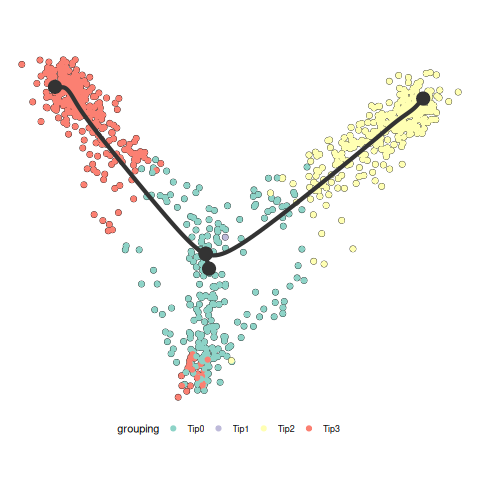

In [25]:
%%R
plot_dimred(dpt_model, color_cells=c("grouping"), dimred=pca_dimred)

In [ ]:
%%R


 [1] "id"                          "cell_ids"                   
 [3] "cell_info"                   "group_ids"                  
 [5] "grouping"                    "milestone_ids"              
 [7] "milestone_network"           "divergence_regions"         
 [9] "milestone_percentages"       "progressions"               
[11] "trajectory_type"             "directed"                   
[13] "dimred"                      "dimred_projected"           
[15] "dimred_milestones"           "dimred_segment_progressions"
[17] "dimred_segment_points"      


In [40]:
%%R
pca_dimred

              comp_1       comp_2      comp_3        comp_4      comp_5
Cell1    -6.21145128 -2.098429540  0.89123555  7.078241e+00 -4.21263784
Cell2     8.75801452 -4.593695033 -3.69279164 -7.282545e-01  2.14540553
Cell3     9.09024209 -3.608349921 -1.06383872 -5.984276e-01  2.43343249
Cell4     2.61972232  6.670609054  2.01077592  4.853469e-01  4.31123788
Cell5    -7.07337252 -3.728014675 -2.18295992 -7.397593e+00 -1.14233242
Cell6    -7.62770997 -4.641883119  1.13844628  1.244646e+00  2.64898978
Cell7     8.56139875 -3.242383462  2.88847096 -4.105585e-01  0.61402855
Cell8    -8.56186104 -3.051685596  0.21063737  1.280998e+00  1.68665067
Cell9     7.39986792 -1.366731783  6.67998730 -1.273019e+00 -2.04651436
Cell10 

   8.19434246 -2.279037091  3.85169014 -1.135285e+00  0.73088153
Cell11   -1.01287177  7.039696917 -0.72665033 -9.152898e-01 -0.06789252
Cell12    9.16724222 -3.486800738  5.09756956 -1.063401e+00  0.55259911
Cell13    6.74707302 -0.530809289  6.04581832 -9.174299e-01 -3.51927234
Cell14   -8.22350467 -3.870673865  1.02212974 -1.405837e+00  2.85704500
Cell15   -1.32924498 10.376330313 -0.08400834  2.194951e+00  2.71519936
Cell16   -2.82976186  6.685425712  0.77246375  9.342036e-02  3.37032101
Cell17   -1.89086177  7.968464114 -0.52888838 -6.037798e-01  0.59932426
Cell18    9.34306107 -3.411785359 -1.17944558 -1.093371e+00  1.91031208
Cell19    5.62544776  0.830904390  5.54514106 -9.251096e-01 -4.00424479
Cell21    7.24652130 -1.930767918 -6.37246230  1.354993e+00 -0.17556498
Cell22   -6.61888358  2.112968509  0.73057120 -3.635318e-01  3.46887704
Cell23   -0.73107372  9.020752750 -0.12952223  9.298316e-01  3.94617848
Cell24    5.18296165 -0.320262885 -7.05515610  2.002818e+00 -1.80788191

In [43]:
%%R
dpt_model$dimred_segment_points

NULL


In [42]:
%%R
print(dpt_model$dimred_segment_progressions, n=200)

# A tibble: 211 × 3
    from  to    percentage
  * <chr> <chr>      <dbl>
  1 Tip0  Tip1      0     
  2 Tip0  Tip1      0.0332
  3 Tip0  Tip1      0.0664
  4 Tip0  Tip1      0.0996
  5 Tip0  Tip1      0.133 
  6 Tip0  Tip1      0.166 
  7 Tip0  Tip1      0.199 
  8 Tip0  Tip1      0.232 
  9 Tip0  Tip1      0.266 
 10 Tip0  Tip1      0.299 
 11 Tip0  Tip1      0.332 
 12 Tip0  Tip1      0.365 
 13 Tip0  Tip1      0.399 
 14 Tip0  Tip1      0.432 
 15 Tip0  Tip1      0.465 
 16 Tip0  Tip1      0.498 
 17 Tip0  Tip1      0.531 
 18 Tip0  Tip1      0.565 
 19 Tip0  Tip1      0.598 
 20 Tip0  Tip1      0.631 
 21 Tip0  Tip1      0.664 
 22 Tip0  Tip1      0.697 
 23 Tip0  Tip1      0.731 
 24 Tip0  Tip1      0.764 
 25 Tip0  Tip1      0.797 
 26 Tip0  Tip1      0.830 
 27 Tip0  Tip1      0.864 
 28 Tip0  Tip1      0.897 
 29 Tip0  Tip1      0.930 
 30 Tip0  Tip1      0.963 
 31 Tip0  Tip1      0.996 
 32 Tip0  Tip1      1     
 33 Tip0  Tip2      0     
 34 Tip0  Tip2      0.0113
 35 Tip0